In [1]:
import sys
import os
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt
import spherical_stats
import math
import pandas as pd
import pingouin as pg


PROJECT_ROOT = os.path.abspath(os.pardir)
sys.path.append(PROJECT_ROOT)

%matplotlib widget

In [2]:
lut = np.load('data/msvelocityDist.npy')
d = np.load('data/msvelocityDist.npz')
energyArray = d['arr_0']
stepsizeArray = d['arr_1']
densityArray = d['arr_2']
p = 3
Ip = np.identity(p)
N = lut.shape[1]

In [3]:
mu = np.array((0, 0, 1.0), dtype=float)
kappaArray = np.zeros(shape=(lut.shape[0], ))
for index in range(lut.shape[0]):
    _, kappa = spherical_stats._vmf._fit(lut[index, :, :])
    kappaArray[index] = kappa
    print(f'Energy: {energyArray[index]}, stepsize: {stepsizeArray[index]}, density: {densityArray[index]}, dispersion: {kappa}')

Energy: 6.1, stepsize: 0.01, density: 1.0, dispersion: 239.10324546389336
Energy: 6.1, stepsize: 0.1, density: 1.0, dispersion: 22.84056187086477
Energy: 20.0, stepsize: 0.01, density: 1.0, dispersion: 1846.2215793908747
Energy: 20.0, stepsize: 0.1, density: 1.0, dispersion: 181.1110705618582


Check for concentrated von Mises-Fisher distribution (Eq. 9.3.15 in Direction Statistics Handbook)

In [4]:
# Multivariate normality test
for index in range(lut.shape[0]):
    data = math.sqrt(kappaArray[index])*(Ip - np.outer(mu, mu)) @ lut[index, :, :].T
    df = pd.DataFrame(data[0:2, :5000].T)
    print(pg.multivariate_normality(df, alpha=.05))
    print(pg.normality(df))

# Individual components not distributed (Shapiro-Wilk test)
# Also not multivariate normal distributed (Henze-Zirkler test)

HZResults(hz=58.86421647476648, pval=7.764251774427381e-88, normal=False)
          W  pval  normal
0  0.848269   0.0   False
1  0.859775   0.0   False
HZResults(hz=5.819919375689986, pval=7.014219247818772e-20, normal=False)
          W          pval  normal
0  0.988585  1.084918e-19   False
1  0.988583  1.080645e-19   False
HZResults(hz=122.62901427901329, pval=6.766290228448904e-120, normal=False)
          W  pval  normal
0  0.734989   0.0   False
1  0.704185   0.0   False
HZResults(hz=22.482122656986327, pval=1.814967423533012e-53, normal=False)
          W          pval  normal
0  0.934088  1.870733e-42   False
1  0.938164  1.823229e-41   False


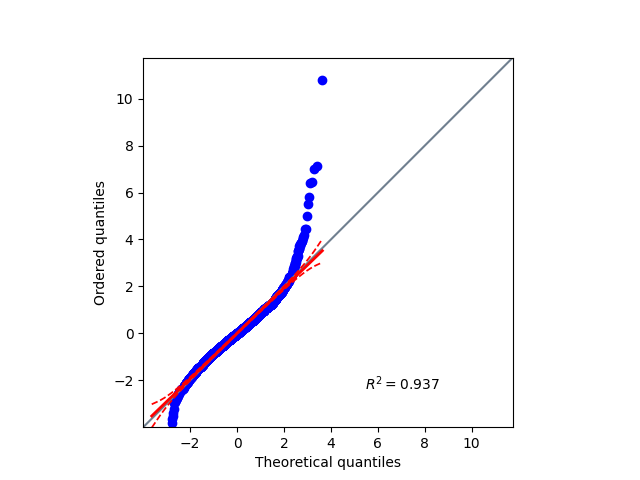

In [5]:
fig, ax = plt.subplots(1, 1)
ax = pg.qqplot(df[1], dist='norm') 
# Indeed, qq plot is not a straight line.
# Conclusion, eq. 9.3.15 does not hold, therefore data does not follow a von Mises-Fischer Distribution (wrapped normal distribution).

Check for von Mises-Fisher distribution

In [6]:
costMS = np.zeros(shape=lut.shape[0:2])
phiMS = np.zeros_like(costMS)
for setup in range(lut.shape[0]):
    for sampleNb in range(lut.shape[1]):
        sample = lut[setup, sampleNb, :]
        costMS[setup, sampleNb] = sample @ mu
        sintMS = math.sqrt(1 - costMS[setup, sampleNb]**2)
        cosphi = lut[setup, sampleNb, 0]/sintMS
        sinphi = lut[setup, sampleNb, 1]/sintMS
        phiMS[setup, sampleNb] = math.atan2(sinphi, cosphi)


Text(0.5, 1.0, 'Azimuthal angle')

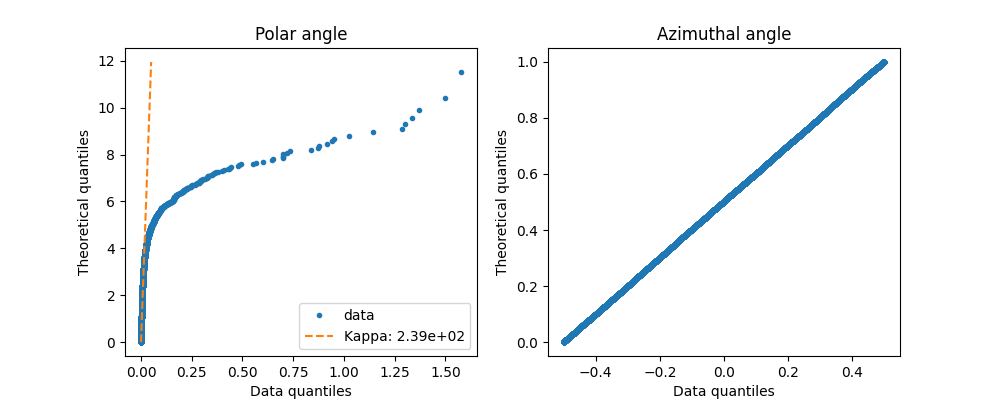

In [7]:
index = 0
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4.0))

yvals = -np.log(1-(np.arange(N)+1/2)/N)
xline = np.linspace(0, 0.05, 20)

ax1.plot(1-np.sort(costMS[index, :]), yvals[::-1], '.', label='data')
ax1.plot(xline, xline*kappaArray[index], '--', label=f'Kappa: {kappaArray[index]:.2e}')
ax1.set_xlabel('Data quantiles')
ax1.set_ylabel('Theoretical quantiles')
ax1.set_title('Polar angle')
ax1.legend()

ax2.plot(np.sort(phiMS[index, :])/(2*math.pi), (np.arange(N)+1/2)/N, '.')
ax2.set_xlabel('Data quantiles')
ax2.set_ylabel('Theoretical quantiles')
ax2.set_title('Azimuthal angle')

In [8]:
# Hypothesis test for concentration parameter kappa. If vMF distribution is correct, the estimated concentration parameter is correct.
index = 0
R = np.linalg.norm(lut[index, :, :].mean(axis=0))
testStatistic = 2*math.pi*kappaArray[index]*(1 - R)
chiq = scipy.stats.chi2.ppf(0.05, (p-1)*(N-1))
print(testStatistic)
print(chiq)

6.283185307179546
99231.66294124367


Polar scattering angle exponentially distributed?


Text(0.5, 1.0, 'Histogram of multiple scattering angle')

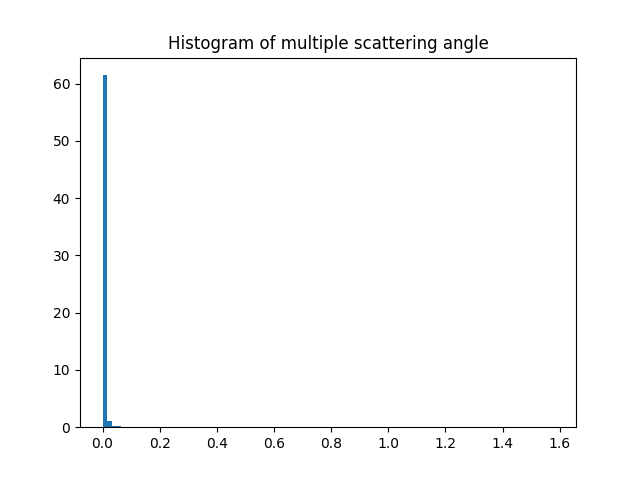

In [9]:
index = 0
fig, ax = plt.subplots(1, 1)
_ = ax.hist(1-costMS[index, :], bins = 100, density=True)
ax.set_title('Histogram of multiple scattering angle')

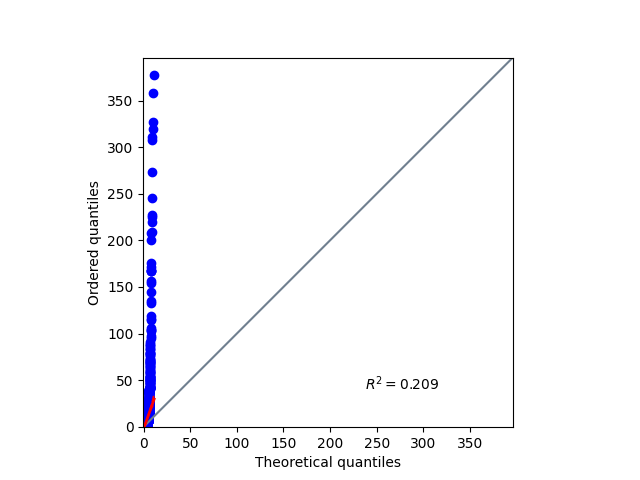

In [10]:
fig, ax = plt.subplots(1, 1)
ax = pg.qqplot(np.sort(1-costMS[index, :]), dist='expon', ax=ax)
